In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# **Load Data Set**

In [54]:
# Load the data
df = pd.read_csv('../Data/data_5KNN.csv')

# Transform it into numpy array
data = df.to_numpy()

In [55]:
# Get the variables
X = data[:,1:]
y = data[:,0]

# Shape
[n, p] = np.shape(X)

# **OLS**

## **Training**

In [56]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Initialize scaler (standardization)
scaler = StandardScaler()

ols_model = LinearRegression()
ols_model.fit(X, y)

LinearRegression()

## $\boldsymbol{\hat{RMSE}}$

In [57]:
from sklearn.model_selection import cross_val_score
# Compute RMSE using cross-validation (5-fold)
# The function cross_val_score takes an average over cross-validation folds
cv_rmse_scores_ols = np.sqrt(-cross_val_score(ols_model, scaler.fit_transform(X), y, scoring='neg_mean_squared_error', cv=5))

# Estimate of RMSE (average over folds)
estimated_RMSE_ols = np.mean(cv_rmse_scores_ols)

print(f"Estimated RMSE for each fold OLS: {cv_rmse_scores_ols}")
print(f"Estimated RMSE (average) OLS: {estimated_RMSE_ols:.4f}")

Estimated RMSE for each fold OLS: [42.02424092 56.59851122 48.56983507 33.86713045 46.19264911]
Estimated RMSE (average) OLS: 45.4505


# **Ridge Regression**

In [58]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

## **Training**

In [59]:
# Define a range of lambda (alpha) values to test
lambda_values = np.logspace(-3, 3, 100)

# Initialize scaler (standardization)
scaler = StandardScaler()

# Define a pipeline that includes normalization and regression to indtroduce in the GridSearchCV
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('ridge', Ridge())             # Apply Ridge Regression
])

# We need a dictionary as an input for the parameters
param_lambda_values = {'ridge__alpha' : lambda_values}

# Perform GridSearchCV to find the best lambda (alpha in this case)
# Its basically a tool to tune/optimize a hyperparamter (lambda in this case)
# its neg_mse beacuse we want to MINIMIZE the score mse (gridsearch always maximizes the score)
ridge_cv = GridSearchCV(estimator=ridge_pipeline, param_grid=param_lambda_values, scoring='neg_mean_squared_error', cv=5) # we obtain min RMSE with 5 folds
ridge_cv.fit(X, y)  # it is using the normalized data stablished in the pipeline

# Get the best lambda
best_lambda_ridge = ridge_cv.best_params_['ridge__alpha']
# Get the best RMSE
ridge_rmse = np.sqrt(-ridge_cv.best_score_)

# Apply one standard error rule
cv_results = ridge_cv.cv_results_
mean_scores = -cv_results['mean_test_score']  # Convert back to MSE
std_scores = cv_results['std_test_score']

# # Way 1: Class
# maxAcc = np.argsort(mean_scores)[0]
# J = np.where(mean_scores[maxAcc] + std_scores[maxAcc] > mean_scores)[0]

# if len(J) > 0:
#     best_lambda_ose = lambda_values[int(J[-1])]
# else:
#     best_lambda_ose = best_lambda_ridge

# Way 2: sklearn
best_idx = ridge_cv.best_index_     # find the indx with the lowest mse
one_std_error = mean_scores[best_idx] + std_scores[best_idx]

# Find the simplest model (largest lambda) within one std error
candidate_indices = np.where(mean_scores <= one_std_error)[0]
best_lambda_ridge_ose = np.max(lambda_values[candidate_indices])

# Get RMSE for OSE lambda
ose_idx = np.where(lambda_values == best_lambda_ridge_ose)[0][0]
ridge_ose_rmse = np.sqrt(-ridge_cv.cv_results_['mean_test_score'][ose_idx])

# Parameters
print(f"Best lambda (original): {ridge_cv.best_params_['ridge__alpha']:.4f} ***** RMSE: {np.sqrt(-ridge_cv.best_score_):.4f}")
print(f"Best lambda (one std error): {best_lambda_ridge_ose:.4f} ***** RMSE: {ridge_ose_rmse:.4f}")

# Fit Ridge with the one std error lambda
best_ridge = Ridge(alpha=best_lambda_ridge_ose)
best_ridge.fit(scaler.fit_transform(X), y)

Best lambda (original): 5.7224 ***** RMSE: 35.9119
Best lambda (one std error): 35.1119 ***** RMSE: 40.0059


Ridge(alpha=35.111917342151344)

## **Plots: Model Selection**

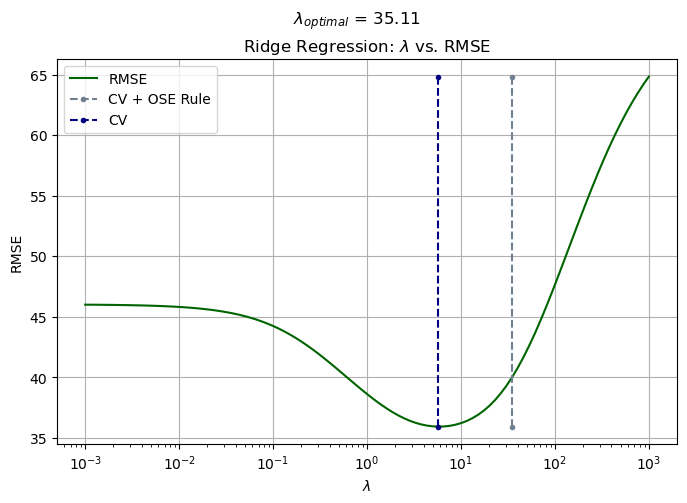

In [60]:
mse_scores = -ridge_cv.cv_results_['mean_test_score']
rmse_scores = np.sqrt(mse_scores)

plt.figure(figsize=(8, 5))
plt.plot(lambda_values, rmse_scores, color='darkgreen', linestyle='-', label='RMSE')
plt.semilogx([best_lambda_ridge_ose, best_lambda_ridge_ose], [np.min(rmse_scores), np.max(rmse_scores)], marker = ".", linestyle = '--', color='slategray', label='CV + OSE Rule')
plt.semilogx([best_lambda_ridge, best_lambda_ridge], [np.min(rmse_scores), np.max(rmse_scores)], marker = ".", linestyle = '--', color='navy', label='CV')
plt.xscale('log')  # Log scale for better visualization
plt.xlabel(r"$\lambda$")
plt.ylabel("RMSE")
plt.suptitle(rf"$\lambda_{{optimal}}$ = {best_lambda_ridge_ose:.2f}", fontsize=12)
plt.title(r"Ridge Regression: $\lambda$ vs. RMSE")
plt.legend()
plt.grid()
plt.show()

## $\boldsymbol{\hat{RMSE}}$

For now, just trying with Kfold CV. Later on we'll try bootstrap etc 

In [61]:
from sklearn.model_selection import cross_val_score

# Compute RMSE using cross-validation (5-fold)
# The function cross_val_score takes an average over cross-validation folds
cv_rmse_scores_ridge = np.sqrt(-cross_val_score(best_ridge, scaler.transform(X), y, scoring='neg_mean_squared_error', cv=5))

# Estimate of RMSE (average over folds)
estimated_RMSE_ridge = np.mean(cv_rmse_scores_ridge)

print(f"Estimated RMSE for each fold Ridge Regression: {cv_rmse_scores_ridge}")
print(f"Estimated RMSE (average) Ridge Regression: {estimated_RMSE_ridge:.4f}")

Estimated RMSE for each fold Ridge Regression: [39.25835371 33.35674673 52.052368   42.09044651 29.45795713]
Estimated RMSE (average) Ridge Regression: 39.2432


# **Lasso Regression**

In [62]:
from sklearn.linear_model import Lasso

## **Training: Cyclical Coordinate Descent**

In [63]:
# Define a range of lambda (alpha) values to test
lambda_values = np.logspace(-3, 3, 100)

# Initialize scaler (standardization)
scaler = StandardScaler()

# Define a pipeline that includes normalization and regression to indtroduce in the GridSearchCV
lasso_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('lasso', Lasso(max_iter=50000))             # Apply Lasso Regression
])

# We need a dictionary as an input for the parameters
param_lambda_values = {'lasso__alpha' : lambda_values}

# Perform GridSearchCV to find the best lambda (alpha in this case)
# Its basically a tool to tune/optimize a hyperparamter (lambda in this case)
# its neg_mse beacuse we want to MINIMIZE the score mse (gridsearch always maximizes the score)
lasso_cv = GridSearchCV(estimator=lasso_pipeline, param_grid=param_lambda_values, scoring='neg_mean_squared_error', cv=5) # we obtain min RMSE with 5 folds
lasso_cv.fit(X, y)  # it is using the normalized data stablished in the pipeline

# Get the best lambda
best_lambda_lasso = lasso_cv.best_params_['lasso__alpha']
# Get the best RMSE
lasso_rmse = np.sqrt(-lasso_cv.best_score_)

# Apply one standard error rule (OSE)
cv_results = lasso_cv.cv_results_
mean_scores = -cv_results['mean_test_score']  # Convert back to MSE
std_scores = cv_results['std_test_score']

best_idx = lasso_cv.best_index_     # find the indx with the lowest mse
one_std_error = mean_scores[best_idx] + std_scores[best_idx]

# Find the simplest model (largest lambda) within one std error
candidate_indices = np.where(mean_scores <= one_std_error)[0]
best_lambda_lasso_ose = np.max(lambda_values[candidate_indices])

# Get RMSE for OSE lambda
ose_idx = np.where(lambda_values == best_lambda_lasso_ose)[0][0]
lasso_ose_rmse = np.sqrt(-lasso_cv.cv_results_['mean_test_score'][ose_idx])

# Parameters
print(f"Best lambda (original): {lasso_cv.best_params_['lasso__alpha']:.4f} ***** RMSE: {np.sqrt(-lasso_cv.best_score_):.4f}")
print(f"Best lambda (one std error): {best_lambda_lasso_ose:.4f} ***** RMSE: {lasso_ose_rmse:.4f}")

# Fit Ridge with the BEST lambda
best_lasso = Lasso(alpha=best_lambda_lasso_ose)
best_lasso.fit(scaler.fit_transform(X), y)  # Transform X before fitting

#######################
# Fit Ridge without the OSE
best_lasso_without_ose = Lasso(alpha=lasso_cv.best_params_['lasso__alpha'])
best_lasso_without_ose.fit(scaler.fit_transform(X), y)  # Transform X before fitting

Best lambda (original): 1.2328 ***** RMSE: 28.1035
Best lambda (one std error): 5.7224 ***** RMSE: 31.3871


Lasso(alpha=1.232846739442066)

Let's check which variables are most relevant.

In [64]:
# Lasso model coefficients are:
lasso_coef = best_lasso.coef_
print(f'There are {sum(lasso_coef != 0)} non-zero coefficients out of {len(lasso_coef)}.')

There are 12 non-zero coefficients out of 116.


## **Plot: Cyclical Coordinate Descent**

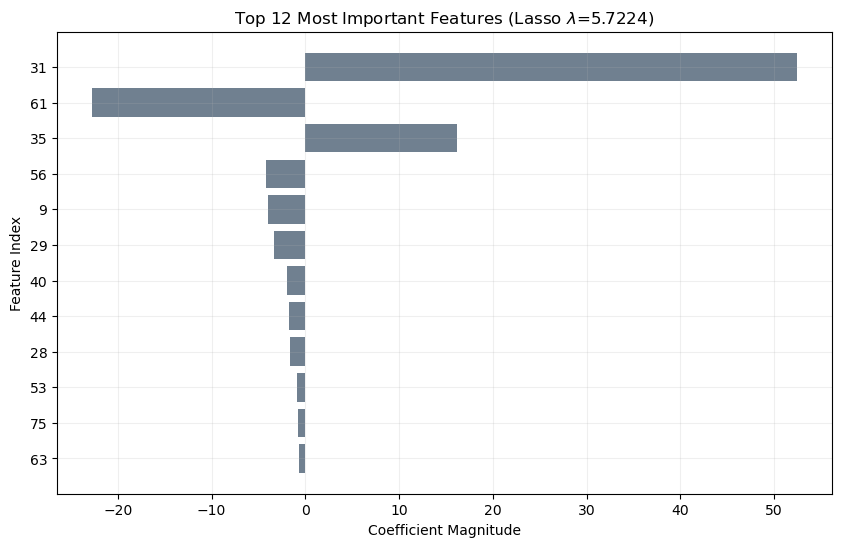

In [65]:
feature_indices = np.arange(X.shape[1])

# Get coefficients and sort by absolute value
sorted_idx = np.argsort(np.abs(lasso_coef))[::-1]
sorted_coefs = lasso_coef[sorted_idx]
sorted_features = feature_indices[sorted_idx]

# Plot top 15 features
plt.figure(figsize=(10, 6))
plt.barh(range(sum(lasso_coef != 0)), sorted_coefs[:sum(lasso_coef != 0)], align='center',color='slategray')
plt.yticks(range(sum(lasso_coef != 0)), sorted_features[:sum(lasso_coef != 0)])
plt.title(rf'Top {sum(lasso_coef != 0)} Most Important Features (Lasso $\lambda$={best_lambda_lasso_ose:.4f})')
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Feature Index')
plt.grid(alpha=0.2)
plt.gca().invert_yaxis()  # Highest coefficient at top
plt.show()

## $\boldsymbol{\hat{RMSE}}$**: Cyclical Coordinate Descent**

In [66]:
from sklearn.model_selection import cross_val_score
# Compute RMSE using cross-validation (5-fold)
# The function cross_val_score takes an average over cross-validation folds
cv_rmse_scores_lasso = np.sqrt(-cross_val_score(best_lasso, scaler.transform(X), y, scoring='neg_mean_squared_error', cv=5))

# Estimate of RMSE (average over folds)
estimated_RMSE_lasso = np.mean(cv_rmse_scores_lasso)

print(f"Estimated RMSE for each fold Lasso (OSE rule): {cv_rmse_scores_lasso}")
print(f"Estimated RMSE (average) Lasso: (OSE rule) {estimated_RMSE_lasso:.4f}")


#####################
# Without the OSE
cv_rmse_scores_lasso_without_ose = np.sqrt(-cross_val_score(best_lasso_without_ose, scaler.transform(X), y, scoring='neg_mean_squared_error', cv=5))

# Estimate of RMSE (average over folds)
estimated_RMSE_lasso_without_ose = np.mean(cv_rmse_scores_lasso_without_ose)

print(f"Estimated RMSE for each fold Lasso: {cv_rmse_scores_lasso_without_ose}")
print(f"Estimated RMSE (average) Lasso: {estimated_RMSE_lasso_without_ose:.4f}")

Estimated RMSE for each fold Lasso (OSE rule): [29.51097621 19.2672305  36.35718043 40.469018   27.99989262]
Estimated RMSE (average) Lasso: (OSE rule) 30.7209
Estimated RMSE for each fold Lasso: [27.80011503 21.33276219 32.25460935 31.06556915 26.17784977]
Estimated RMSE (average) Lasso: 27.7262


#################################################################################################################

In [67]:
from sklearn.linear_model import LassoLars

## **Training: LARS**

In [68]:
# Define a range of lambda (alpha) values to test
lambda_values = np.logspace(-3, 3, 100)

# Initialize scaler (standardization)
scaler = StandardScaler()

# Define a pipeline that includes normalization and regression to indtroduce in the GridSearchCV
lasso_lars_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('lasso_lars', LassoLars())             # Apply Lasso LARS Regression
])

# We need a dictionary as an input for the parameters
param_lambda_values = {'lasso_lars__alpha' : lambda_values}

# Perform GridSearchCV to find the best lambda (alpha in this case)
# Its basically a tool to tune/optimize a hyperparamter (lambda in this case)
# its neg_mse beacuse we want to MINIMIZE the score mse (gridsearch always maximizes the score)
lasso_lars_cv = GridSearchCV(estimator=lasso_lars_pipeline, param_grid=param_lambda_values, scoring='neg_mean_squared_error', cv=5) # we obtain min RMSE with 5 folds
lasso_lars_cv.fit(X, y)  # it is using the normalized data stablished in the pipeline

# Get the best lambda
best_lambda_lasso_lars = lasso_lars_cv.best_params_['lasso_lars__alpha']
# Get the best RMSE
lasso_lars_rmse = np.sqrt(-lasso_lars_cv.best_score_)

# Apply one standard error rule (OSE)
cv_results = lasso_lars_cv.cv_results_
mean_scores = -cv_results['mean_test_score']  # Convert back to MSE
std_scores = cv_results['std_test_score']

best_idx = lasso_lars_cv.best_index_     # find the indx with the lowest mse
one_std_error = mean_scores[best_idx] + std_scores[best_idx]

# Find the simplest model (largest lambda) within one std error
candidate_indices = np.where(mean_scores <= one_std_error)[0]
best_lambda_lasso_lars_ose = np.max(lambda_values[candidate_indices])

# Get RMSE for OSE lambda
ose_idx = np.where(lambda_values == best_lambda_lasso_lars_ose)[0][0]
lasso_lars_ose_rmse = np.sqrt(-lasso_lars_cv.cv_results_['mean_test_score'][ose_idx])

# Parameters
print(f"Best lambda Lasso LARS (original): {lasso_lars_cv.best_params_['lasso_lars__alpha']:.4f} ***** RMSE: {np.sqrt(-lasso_lars_cv.best_score_):.4f}")
print(f"Best lambda Lasso LARS (one std error): {best_lambda_lasso_lars_ose:.4f} ***** RMSE: {lasso_lars_ose_rmse:.4f}")

# Fit Ridge with the BEST lambda
best_lasso_lars = LassoLars(alpha=best_lambda_lasso_lars_ose)
best_lasso_lars.fit(scaler.fit_transform(X), y)  # Transform X before fitting

Best lambda Lasso LARS (original): 1.4175 ***** RMSE: 28.1015
Best lambda Lasso LARS (one std error): 5.7224 ***** RMSE: 31.3881


LassoLars(alpha=5.72236765935022)

## **Plot: Cyclical Coordinate Descent**

In [69]:
# Lasso model coefficients are:
lasso_lars_coef = best_lasso_lars.coef_
print(f'There are {sum(lasso_lars_coef != 0)} non-zero coefficients out of {len(lasso_lars_coef)}.')

There are 12 non-zero coefficients out of 116.


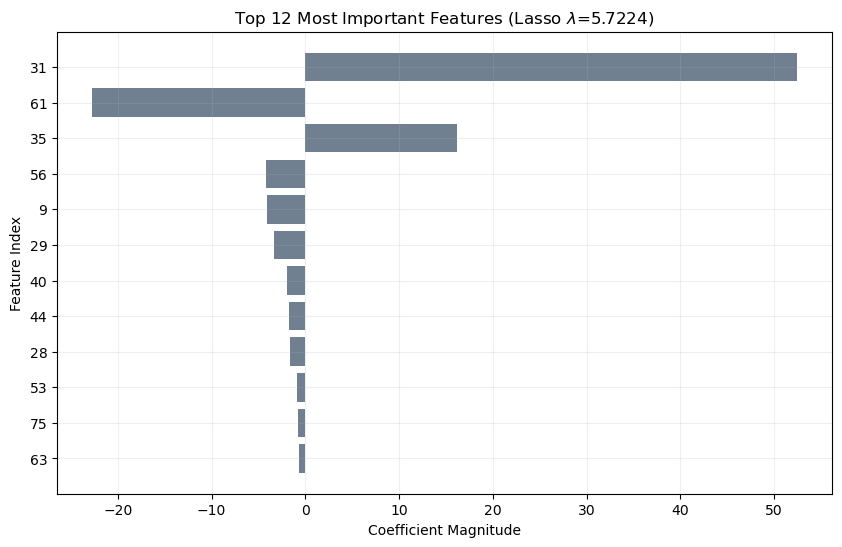

In [70]:
feature_indices = np.arange(X.shape[1])

# Get coefficients and sort by absolute value
sorted_idx = np.argsort(np.abs(lasso_lars_coef))[::-1]
sorted_coefs = lasso_lars_coef[sorted_idx]
sorted_features = feature_indices[sorted_idx]

# Plot top 15 features
plt.figure(figsize=(10, 6))
plt.barh(range(sum(lasso_lars_coef != 0)), sorted_coefs[:sum(lasso_lars_coef != 0)], align='center',color='slategray')
plt.yticks(range(sum(lasso_lars_coef != 0)), sorted_features[:sum(lasso_lars_coef != 0)])
plt.title(rf'Top {sum(lasso_lars_coef != 0)} Most Important Features (Lasso $\lambda$={best_lambda_lasso_lars_ose:.4f})')
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Feature Index')
plt.grid(alpha=0.2)
plt.gca().invert_yaxis()  # Highest coefficient at top
plt.show()

## $\boldsymbol{\hat{RMSE}}$**: LARS** 

In [71]:
from sklearn.model_selection import cross_val_score
# Compute RMSE using cross-validation (5-fold)
# The function cross_val_score takes an average over cross-validation folds
cv_rmse_scores_lasso_lars = np.sqrt(-cross_val_score(best_lasso_lars, scaler.transform(X), y, scoring='neg_mean_squared_error', cv=5))

# Estimate of RMSE (average over folds)
estimated_RMSE_lasso_lars = np.mean(cv_rmse_scores_lasso_lars)

print(f"Estimated RMSE for each fold Lasso LARS: {cv_rmse_scores_lasso_lars}")
print(f"Estimated RMSE (average) Lasso LARS: {estimated_RMSE_lasso_lars:.4f}")

Estimated RMSE for each fold Lasso LARS: [29.51164087 19.26843998 36.35986392 40.4690479  27.999391  ]
Estimated RMSE (average) Lasso LARS: 30.7217


As expected, we reach the same conclusion as in the previous section (with the conjgate coordinate descent method). However, LARS implementation is converges faster.

# **Elastic Net Regression** 

In [72]:
from sklearn.linear_model import ElasticNet

In [73]:
# Now we have to train 2 parameters: lambda and the ratio
# Define a range of lambda (alpha) values and l1_ratio values to test
lambda_values = np.logspace(-3, 3, 100)  # Similar range for alpha
l1_ratios = np.linspace(0.05, 0.95, 19)   # Mix ratio between Lasso (L1) and Ridge (L2)

# Define a pipeline that includes normalization and regression to introduce in GridSearchCV
elasticnet_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('elasticnet', ElasticNet(max_iter=20000))  # Apply ElasticNet with a high iteration limit
])

# We need a dictionary as an input for the parameters
param_grid = {
    'elasticnet__alpha': lambda_values,
    'elasticnet__l1_ratio': l1_ratios  # The mix ratio between Lasso and Ridge
}

# Perform GridSearchCV to find the best lambda and l1_ratio
elasticnet_cv = GridSearchCV(estimator=elasticnet_pipeline, param_grid=param_grid,
                             scoring='neg_mean_squared_error', cv=5, n_jobs=-1) # Use all processors
elasticnet_cv.fit(X, y)  # Uses the normalized data established in the pipeline

# Get the best parameters (lambda and l1_ratio)
best_lambda_elasticnet = elasticnet_cv.best_params_['elasticnet__alpha']
best_l1_ratio_elasticnet = elasticnet_cv.best_params_['elasticnet__l1_ratio']
# Get the best RMSE
elasticnet_rmse = np.sqrt(-elasticnet_cv.best_score_)

### Apply one standard error rule (OSE) for ElasticNet with two parameters
cv_results = elasticnet_cv.cv_results_
mean_scores = -cv_results['mean_test_score']  # Convert back to MSE
std_scores = cv_results['std_test_score']

# Get the best parameter combination index
best_idx = elasticnet_cv.best_index_
one_std_error = mean_scores[best_idx] + std_scores[best_idx]

# Find all models within one std error
candidate_indices = np.where(mean_scores <= one_std_error)[0]

# Get parameter combinations for all candidates
candidate_params = [elasticnet_cv.cv_results_['params'][i] for i in candidate_indices]

# For ElasticNet, we want the simplest model within one std error
# Prioritize higher alpha (lambda) first, then higher l1_ratio (more sparsity)
# Sort by alpha (descending), then by l1_ratio (descending)
sorted_candidates = sorted(
    candidate_params, 
    key=lambda x: (x['elasticnet__alpha'], x['elasticnet__l1_ratio']),
    reverse=True
)

# Select the simplest model (highest alpha, then highest l1_ratio)
best_params_ose = sorted_candidates[0]
best_lambda_elasticnet_ose = best_params_ose['elasticnet__alpha']
best_l1_ratio_ose = best_params_ose['elasticnet__l1_ratio']

# Get RMSE for OSE parameters
ose_idx = candidate_indices[0]  # Index of the simplest model
elasticnet_ose_rmse = np.sqrt(mean_scores[ose_idx])

# Print results
print(f"Best parameters (original): lambda={elasticnet_cv.best_params_['elasticnet__alpha']:.4f}, l1_ratio={elasticnet_cv.best_params_['elasticnet__l1_ratio']:.4f}")
print(f"***** Best RMSE (original): {np.sqrt(-elasticnet_cv.best_score_):.4f} *****")
print(f"Best parameters (one std error): lambda={best_lambda_elasticnet_ose:.4f}, l1_ratio={best_l1_ratio_ose:.4f}")
print(f"***** Best RMSE (one std error): {elasticnet_ose_rmse:.4f} *****")

# Fit ElasticNet with the best hyperparameters
best_elasticnet = ElasticNet(alpha=best_lambda_elasticnet_ose, l1_ratio=best_l1_ratio_ose, max_iter=20000)
best_elasticnet.fit(StandardScaler().fit_transform(X), y)  # Transform X before fitting

Best parameters (original): lambda=0.7055, l1_ratio=0.9500
***** Best RMSE (original): 31.5830 *****
Best parameters (one std error): lambda=3.2745, l1_ratio=0.9500
***** Best RMSE (one std error): 35.2951 *****


ElasticNet(alpha=3.2745491628777286, l1_ratio=0.95, max_iter=20000)

Makes sense that the best l1_ratio is 0.95, as we have seen that Lasso performs better than Ridge in this data set!!

## $\boldsymbol{\hat{RMSE}}$**: Elastic Net** 

In [74]:
from sklearn.model_selection import cross_val_score
# Compute RMSE using cross-validation (5-fold)
# The function cross_val_score takes an average over cross-validation folds
cv_rmse_scores_elasticnet = np.sqrt(-cross_val_score(best_elasticnet, scaler.transform(X), y, scoring='neg_mean_squared_error', cv=5))

# Estimate of RMSE (average over folds)
estimated_RMSE_elasticnet = np.mean(cv_rmse_scores_elasticnet)

print(f"Estimated RMSE for each fold Elastic Net: {cv_rmse_scores_elasticnet}")
print(f"Estimated RMSE (average) Elastic Net: {estimated_RMSE_elasticnet:.4f}")

Estimated RMSE for each fold Elastic Net: [33.98934376 25.11006158 42.99400956 41.84636739 27.42581897]
Estimated RMSE (average) Elastic Net: 34.2731


# **Model Selection**

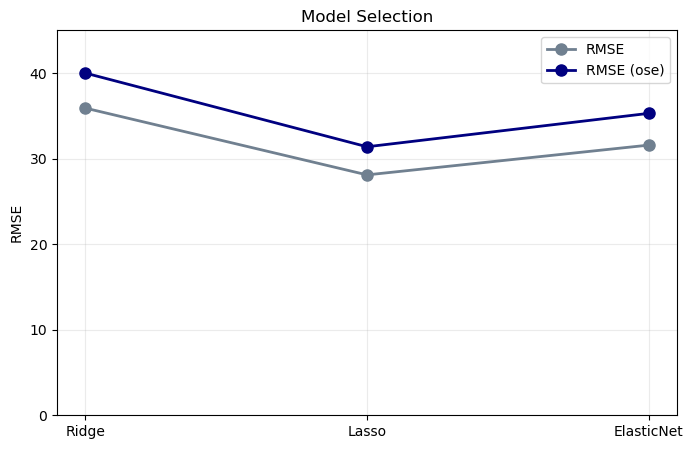

In [81]:
# RMSE values for the five models
models = ['Ridge', 'Lasso', 'ElasticNet']
# models = ['OLS', 'Ridge', 'Lasso CC', 'LARS', 'ElasticNet','CART', 'Bagging','RF']

rmse_values_ose = [ridge_ose_rmse, lasso_lars_ose_rmse, elasticnet_ose_rmse]
rmse_values = [ridge_rmse, lasso_lars_rmse, elasticnet_rmse]

# Create the line plot
plt.figure(figsize=(8, 5))
plt.plot(models, rmse_values, marker='o', linestyle='-', color='slategray', linewidth=2, markersize=8, label='RMSE')
plt.plot(models, rmse_values_ose, marker='o', linestyle='-', color='navy', linewidth=2, markersize=8, label='RMSE (ose)')

# Labels and title
plt.ylabel('RMSE')
plt.title('Model Selection')
plt.ylim(0, max(rmse_values_ose) + 5)  # Adjust y-axis range for better visualization

# Show plot
plt.legend()
plt.grid(True, alpha=.25)
plt.show()


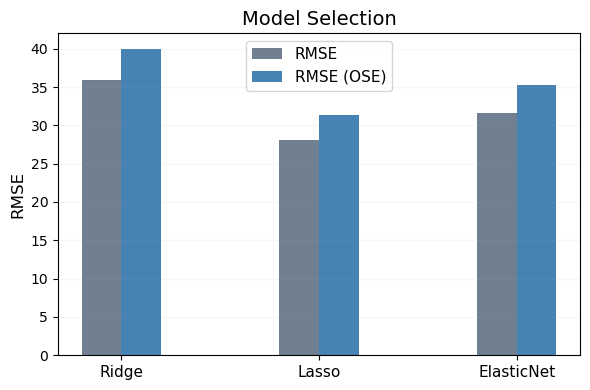

In [93]:
# RMSE values for the models
models = ['Ridge', 'Lasso', 'ElasticNet']
rmse_values_ose = [ridge_ose_rmse, lasso_lars_ose_rmse, elasticnet_ose_rmse]
rmse_values = [ridge_rmse, lasso_lars_rmse, elasticnet_rmse]

plt.figure(figsize=(6, 4))
x = np.arange(len(models))
width = 0.2

plt.bar(x - width/2, rmse_values, width, color='slategray', label='RMSE')
plt.bar(x + width/2, rmse_values_ose, width, color='steelblue', label='RMSE (OSE)')

plt.ylabel('RMSE', fontsize=12)
plt.title('Model Selection', fontsize=14)
plt.xticks(x, models, fontsize=11)
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.1)
plt.tight_layout()
plt.show()

# **Model Assesment**

## **K-Fold Cross Validation** (data leakage)

In [97]:
from sklearn.model_selection import cross_val_score

In [119]:
# Number of K-folds
k = 5

## $\boldsymbol{\hat{RMSE_{ols}}}$

In [120]:
# Compute RMSE using cross-validation (5-fold)
# The function cross_val_score takes an average over cross-validation folds
cv_rmse_scores_ols = np.sqrt(-cross_val_score(ols_model, scaler.fit_transform(X), y, scoring='neg_mean_squared_error', cv=k))

# Estimate of RMSE (average over folds)
estimated_RMSE_ols = np.mean(cv_rmse_scores_ols)

print(f"Estimated RMSE for each fold OLS: {cv_rmse_scores_ols}")
print(f"Estimated RMSE (average) OLS: {estimated_RMSE_ols:.4f}")

Estimated RMSE for each fold OLS: [42.02424092 56.59851122 48.56983507 33.86713045 46.19264911]
Estimated RMSE (average) OLS: 45.4505


## $\boldsymbol{\hat{RMSE_{ridge}}}$

In [121]:
# Compute RMSE using cross-validation (5-fold)
# The function cross_val_score takes an average over cross-validation folds
cv_rmse_scores_ridge = np.sqrt(-cross_val_score(best_ridge, scaler.transform(X), y, scoring='neg_mean_squared_error', cv=k))

# Estimate of RMSE (average over folds)
estimated_RMSE_ridge = np.mean(cv_rmse_scores_ridge)

print(f"Estimated RMSE for each fold Ridge Regression: {cv_rmse_scores_ridge}")
print(f"Estimated RMSE (average) Ridge Regression: {estimated_RMSE_ridge:.4f}")

Estimated RMSE for each fold Ridge Regression: [39.25835371 33.35674673 52.052368   42.09044651 29.45795713]
Estimated RMSE (average) Ridge Regression: 39.2432


## $\boldsymbol{\hat{RMSE_{lasso}}}$

In [122]:
# Compute RMSE using cross-validation (5-fold)
# The function cross_val_score takes an average over cross-validation folds
cv_rmse_scores_lasso_lars = np.sqrt(-cross_val_score(best_lasso_lars, scaler.transform(X), y, scoring='neg_mean_squared_error', cv=k))

# Estimate of RMSE (average over folds)
estimated_RMSE_lasso_lars = np.mean(cv_rmse_scores_lasso_lars)

print(f"Estimated RMSE for each fold Lasso LARS: {cv_rmse_scores_lasso_lars}")
print(f"Estimated RMSE (average) Lasso LARS: {estimated_RMSE_lasso_lars:.4f}")

Estimated RMSE for each fold Lasso LARS: [29.51164087 19.26843998 36.35986392 40.4690479  27.999391  ]
Estimated RMSE (average) Lasso LARS: 30.7217


## $\boldsymbol{\hat{RMSE_{elasticnet}}}$

In [123]:
# Compute RMSE using cross-validation (5-fold)
# The function cross_val_score takes an average over cross-validation folds
cv_rmse_scores_elasticnet = np.sqrt(-cross_val_score(best_elasticnet, scaler.transform(X), y, scoring='neg_mean_squared_error', cv=k))

# Estimate of RMSE (average over folds)
estimated_RMSE_elasticnet = np.mean(cv_rmse_scores_elasticnet)

print(f"Estimated RMSE for each fold Elastic Net: {cv_rmse_scores_elasticnet}")
print(f"Estimated RMSE (average) Elastic Net: {estimated_RMSE_elasticnet:.4f}")

Estimated RMSE for each fold Elastic Net: [33.98934376 25.11006158 42.99400956 41.84636739 27.42581897]
Estimated RMSE (average) Elastic Net: 34.2731


Plotting

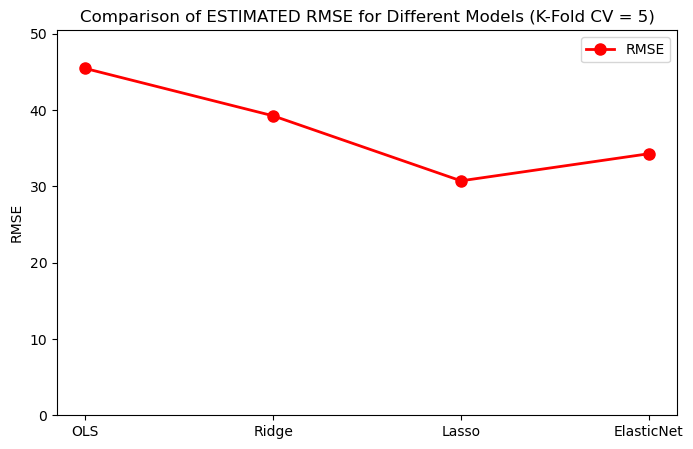

In [124]:
# RMSE values for the five models
models = ['OLS', 'Ridge', 'Lasso', 'ElasticNet']
# models = ['OLS', 'Ridge', 'Lasso CC', 'LARS', 'ElasticNet','CART', 'Bagging','RF']
rmse_values = [estimated_RMSE_ols, estimated_RMSE_ridge, 
               estimated_RMSE_lasso_lars, estimated_RMSE_elasticnet]  # Replace with actual values

# Create the line plot
plt.figure(figsize=(8, 5))
plt.plot(models, rmse_values, marker='o', linestyle='-', color='red', linewidth=2, markersize=8, label='RMSE')

# Labels and title
plt.ylabel('RMSE')
plt.title('Comparison of ESTIMATED RMSE for Different Models (K-Fold CV = 5)')
plt.ylim(0, max(rmse_values) + 5)  # Adjust y-axis range for better visualization

# Show plot
plt.legend()
plt.show()


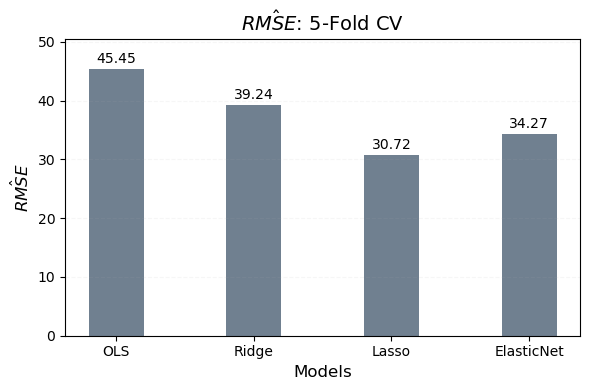

In [127]:
# RMSE values for the models
models = ['OLS', 'Ridge', 'Lasso', 'ElasticNet']
rmse_values = [estimated_RMSE_ols, estimated_RMSE_ridge, 
               estimated_RMSE_lasso_lars, estimated_RMSE_elasticnet]

# Create the bar plot
plt.figure(figsize=(6, 4))
bars = plt.bar(models, rmse_values, color='slategray', width=0.4)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height:.2f}', ha='center', va='bottom')

# Labels and title
plt.ylabel(r'$\hat{RMSE}$', fontsize=12)
plt.xlabel('Models', fontsize=12)
plt.title(rf'$\hat{{RMSE}}$: {k}-Fold CV', fontsize=14)
plt.ylim(0, max(rmse_values) + 5)  # Adjust y-axis range for better visualization

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.1)
plt.tight_layout()
plt.show()

## **Leave One Out Cross Validation**

## **Bootstrap**